In [1]:
!pip install optuna scikit-learn seaborn scipy xgboost lightgbm joblib plotly tqdm --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from scipy.stats import spearmanr, pearsonr
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
import plotly.express as px
import os

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Конфигурация
DATA_PATH = '/content/drive/MyDrive/data_c/data_fe.csv'
SAVE_DIR = '/content/drive/MyDrive/data_c/model_results'
os.makedirs(SAVE_DIR, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:

# Загрузка и подготовка данных
print("Загрузка данных...")
data = pd.read_csv(DATA_PATH)
print(f"Данные загружены, форма: {data.shape}")

# Определение признаков и целевых переменных
targets = ['IC50', 'pIC50']
features = [col for col in data.columns if col not in ['IC50', 'pIC50', 'CC50',
                                                       'pCC50', 'SI', 'SI_log']]

# Разделение данных
X = data[features]
y = data[targets]
X_train, X_test, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2,
                                                          random_state=42)
print(f"\nРазделение данных:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)


Загрузка данных...
Данные загружены, форма: (998, 167)

Разделение данных:
Train: (798, 161), Test: (200, 161)


In [3]:

# Выбор лучшей целевой переменной
print("\nВыбор целевой переменной...")
rmse_results = {}
for target in tqdm(targets, desc="Оценка целей"):
    X_temp, X_val, y_temp, y_val = train_test_split(
        X_train_scaled,
        y_train_df[target].values,
        test_size=0.2,
        random_state=42
    )

    # Отбор признаков
    mi = mutual_info_regression(X_temp, y_temp)
    top50_idx = np.argsort(mi)[::-1][:50]
    X_tr_sel = X_temp.iloc[:, top50_idx]
    X_val_sel = X_val.iloc[:, top50_idx]

    # Оценка модели
    lr = LinearRegression()
    lr.fit(X_tr_sel, y_temp)
    y_pred = lr.predict(X_val_sel)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_results[target] = rmse

best_target = min(rmse_results, key=rmse_results.get)
print(f"\nЛучшая цель: {best_target} (RMSE: {rmse_results[best_target]:.4f})")
y_train = y_train_df[best_target].values
y_test = y_test_df[best_target].values



Выбор целевой переменной...


Оценка целей: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Лучшая цель: pIC50 (RMSE: 0.8099)


In [4]:

# Отбор признаков ансамблевым методом
print("\nОтбор признаков...")
selector = SelectFromModel(
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    max_features=50
)
selector.fit(X_train_scaled, y_train)
best_idx = selector.get_support(indices=True)
selected_features = [features[i] for i in best_idx]

print("\nТоп-10 отобранных признаков:")
for i, feature in enumerate(selected_features[:10]):
    print(f"{i+1}. {feature}")

# Подготовка финальных данных
X_train_final = X_train_scaled[selected_features]
X_test_final = X_test_scaled[selected_features]
print(f"\nФинальная размерность: {X_train_final.shape[1]} признаков")



Отбор признаков...

Топ-10 отобранных признаков:
1. MaxAbsEStateIndex
2. MinAbsEStateIndex
3. MinEStateIndex
4. qed
5. MolWt
6. MaxPartialCharge
7. MinPartialCharge
8. FpDensityMorgan1
9. BCUT2D_MWHI
10. BCUT2D_MWLOW

Финальная размерность: 50 признаков


In [5]:

# Сравнение моделей
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GB': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1)
}

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    r, _ = pearsonr(y_test, pred)

    return rmse, mae, r2, r

print("\nСравнение моделей:")
metrics = {}
for name, model in tqdm(models.items(), desc="Обучение моделей"):
    rmse, mae, r2, r = evaluate_model(model, X_train_final, y_train,
                                      X_test_final, y_test, name)
    metrics[name] = (rmse, mae, r2, r)
    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, Pearsonr={r:.4f}")



Сравнение моделей:


Обучение моделей:  29%|██▊       | 2/7 [00:00<00:00, 14.75it/s]

Linear: RMSE=0.7974, MAE=0.6345, R²=0.3819, Pearsonr=0.6183
Ridge: RMSE=0.7975, MAE=0.6341, R²=0.3818, Pearsonr=0.6182
Lasso: RMSE=0.9419, MAE=0.7424, R²=0.1376, Pearsonr=0.4250


Обучение моделей:  57%|█████▋    | 4/7 [00:04<00:04,  1.45s/it]

RF: RMSE=0.7152, MAE=0.5442, R²=0.5028, Pearsonr=0.7115


Обучение моделей:  71%|███████▏  | 5/7 [00:07<00:03,  1.73s/it]

GB: RMSE=0.7175, MAE=0.5606, R²=0.4996, Pearsonr=0.7094


Обучение моделей:  86%|████████▌ | 6/7 [00:22<00:05,  5.59s/it]

XGBoost: RMSE=0.7216, MAE=0.5409, R²=0.4938, Pearsonr=0.7158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9910
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 50
[LightGBM] [Info] Start training from score -1.657241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Обучение моделей: 100%|██████████| 7/7 [00:22<00:00,  3.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

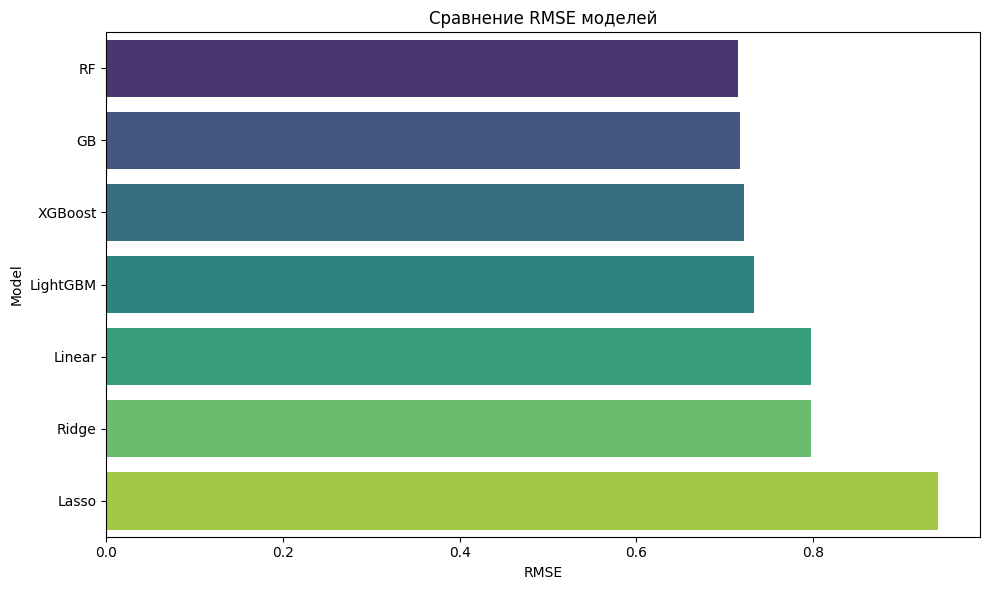


Лучшая модель: RF (RMSE: 0.7152)


In [6]:

# Визуализация сравнения
rmse_df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'RMSE': [metrics[name][0] for name in metrics]
}).sort_values('RMSE')

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_df, palette='viridis')
plt.title('Сравнение RMSE моделей')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/model_comparison.png')
plt.show()

best_model_name = rmse_df.iloc[0]['Model']
best_base = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name} (RMSE: {rmse_df.iloc[0]['RMSE']:.4f})")


In [7]:

# Оптимизация гиперпараметров Optuna
def get_param_func(name):
    if name == 'Ridge':
        return lambda t: {'alpha': t.suggest_float('alpha', 0.01, 100, log=True)}
    if name == 'Lasso':
        return lambda t: {'alpha': t.suggest_float('alpha', 0.01, 100, log=True)}
    if name == 'RF':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 5, 50),
            'min_samples_split': t.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': t.suggest_int('min_samples_leaf', 1, 10),
            'max_features': t.suggest_categorical('max_features', ['sqrt', 'log2', 0.8]),
            'random_state': 42,
            'n_jobs': -1
        }
    if name == 'GB':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 10),
            'learning_rate': t.suggest_float('learning_rate', 0.001, 0.2, log=True),
            'subsample': t.suggest_float('subsample', 0.5, 1.0),
            'min_samples_leaf': t.suggest_int('min_samples_leaf', 1, 10),
            'random_state': 42
        }
    if name == 'XGBoost':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 12),
            'learning_rate': t.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': t.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': t.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': t.suggest_float('gamma', 0, 1),
            'reg_alpha': t.suggest_float('reg_alpha', 0, 1),
            'random_state': 42,
            'n_jobs': -1
        }
    if name == 'LightGBM':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 15),
            'learning_rate': t.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': t.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': t.suggest_float('colsample_bytree', 0.6, 1.0),
            'num_leaves': t.suggest_int('num_leaves', 20, 200),
            'min_child_samples': t.suggest_int('min_child_samples', 5, 50),
            'reg_alpha': t.suggest_float('reg_alpha', 0, 1),
            'random_state': 42,
            'n_jobs': -1
        }
    return None

param_func = get_param_func(best_model_name)

if best_model_name not in ['Linear'] and param_func is not None:
    print(f"\nОптимизация {best_model_name} с Optuna...")

    def objective(trial):
        params = param_func(trial)
        ModelClass = type(best_base)
        model = ModelClass(**params)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for tr_idx, val_idx in kf.split(X_train_final):
            X_tr, y_tr = X_train_final.iloc[tr_idx], y_train[tr_idx]
            X_val, y_val = X_train_final.iloc[val_idx], y_train[val_idx]

            model.fit(X_tr, y_tr)
            val_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            scores.append(rmse)

        return np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("\nЛучшие гиперпараметры:")
    for k, v in study.best_params.items():
        print(f"{k}: {v}")
    print(f"Лучшее значение RMSE: {study.best_value:.4f}")

    # Обучение финальной модели
    ModelClass = type(best_base)
    optimized = ModelClass(**study.best_params)
    optimized.fit(X_train_final, y_train)

    # Кросс-валидация
    cv_scores = cross_val_score(
        optimized,
        X_train_final,
        y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    cv_rmse = -cv_scores.mean()
    print(f"Cross-Validation RMSE: {cv_rmse:.4f} (±{-cv_scores.std():.4f})")

    # Оценка на тесте
    test_pred = optimized.predict(X_test_final)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    print(f"Тестовый RMSE: {test_rmse:.4f}")

    # Ансамблирование
    print("\nСоздание ансамбля из 5 моделей...")
    ensemble_preds = []
    for i in tqdm(range(5), desc="Обучение ансамбля"):
        model = ModelClass(**study.best_params)
        model.set_params(**{'random_state': 42 + i})
        model.fit(X_train_final, y_train)
        pred_i = model.predict(X_test_final)
        ensemble_preds.append(pred_i)

    ensemble_pred = np.mean(ensemble_preds, axis=0)
    ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    print(f"RMSE ансамбля: {ensemble_rmse:.4f}")

    final_pred = ensemble_pred
    final_rmse = ensemble_rmse
else:
    print("\nОптимизация не требуется")
    optimized = best_base
    optimized.fit(X_train_final, y_train)
    final_pred = optimized.predict(X_test_final)
    final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))


[I 2025-06-18 10:46:17,416] A new study created in memory with name: no-name-3894a035-a37c-47c8-9421-cef4ab11b284



Оптимизация RF с Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-18 10:46:29,031] Trial 0 finished with value: 0.6964395380404463 and parameters: {'n_estimators': 664, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6964395380404463.
[I 2025-06-18 10:46:36,951] Trial 1 finished with value: 0.6928048836998751 and parameters: {'n_estimators': 594, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.6928048836998751.
[I 2025-06-18 10:46:41,120] Trial 2 finished with value: 0.6821182744106868 and parameters: {'n_estimators': 187, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6821182744106868.
[I 2025-06-18 10:46:46,181] Trial 3 finished with value: 0.6954997726652233 and parameters: {'n_estimators': 368, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.68211827441068

Обучение ансамбля: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

RMSE ансамбля: 0.7028


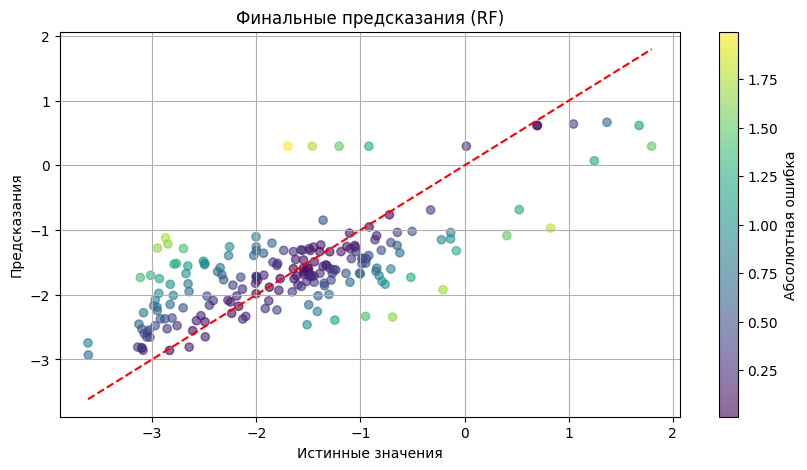

In [8]:

# Финальная визуализация
plt.figure(figsize=(10, 5))
plt.scatter(y_test, final_pred, alpha=0.6, c=np.abs(y_test - final_pred), cmap='viridis')
plt.colorbar(label='Абсолютная ошибка')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title(f'Финальные предсказания ({best_model_name})')
plt.grid(True)
plt.savefig(f'{SAVE_DIR}/final_predictions.png')
plt.show()


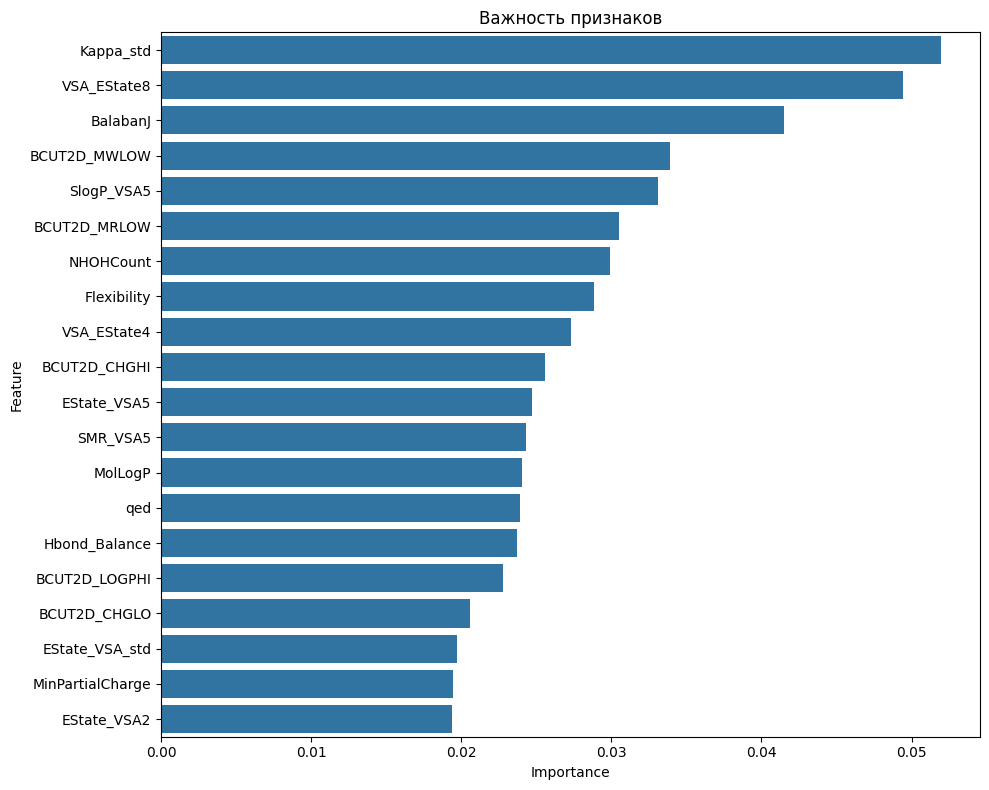

In [9]:

# Анализ важности признаков
if hasattr(optimized, 'feature_importances_'):
    importances = optimized.feature_importances_
    feat_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Топ-20 признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_importance.head(20))
    plt.title('Важность признаков')
    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/feature_importance.png')
    plt.show()

    # Интерактивная визуализация
    fig = px.bar(feat_importance.head(20), x='Importance', y='Feature', orientation='h')
    fig.write_html(f'{SAVE_DIR}/feature_importance.html')

    feat_importance.to_csv(f'{SAVE_DIR}/feature_importance.csv', index=False)


In [10]:

# Анализ ошибок
errors = y_test - final_pred
max_error_idx = np.argsort(np.abs(errors))[::-1][:10]
error_df = pd.DataFrame({
    'True Value': y_test[max_error_idx],
    'Predicted Value': final_pred[max_error_idx],
    'Error': errors[max_error_idx]
}, index=y_test_df.index[max_error_idx])

print("\nСоединения с наибольшими ошибками:")
display(error_df)



Соединения с наибольшими ошибками:


,True Value,Predicted Value,Error
798,-1.698089,0.296299,-1.994388
879,0.826739,-0.969366,1.796105
785,-1.462399,0.296299,-1.758698
199,-2.871018,-1.119199,-1.751819
533,-0.207429,-1.922248,1.714819
299,-2.947625,-1.279947,-1.667678
208,-0.691277,-2.343950,1.652673
687,-2.848370,-1.215564,-1.632806
787,-1.204154,0.296299,-1.500453
796,1.795759,0.296299,1.499460


In [11]:

# Сохранение полных результатов
results_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': final_pred,
    'Error': errors
}, index=y_test_df.index)

results_df.to_csv(f'{SAVE_DIR}/predictions_{best_target}_{best_model_name}.csv')
print(f"\nРезультаты сохранены в {SAVE_DIR}")



Результаты сохранены в /content/drive/MyDrive/data_c/model_results


In [12]:

print("\nФинальный отчет:")
print(f"Целевая переменная: {best_target}")
print(f"Лучшая модель: {best_model_name}")
print(f"Финальный RMSE: {final_rmse:.4f}")
print(f"R²: {r2_score(y_test, final_pred):.4f}")
print(f"Pearsonr: {pearsonr(y_test, final_pred)[0]:.4f}")


Финальный отчет:
Целевая переменная: pIC50
Лучшая модель: RF
Финальный RMSE: 0.7028
R²: 0.5199
Pearsonr: 0.7233
